# Text Mining & Social Network Analysis

Se realizará un análisis sobre los tweets más destacados que hablan de los bolones en Guayaquil, se determinará si existen comunidades que apoyan o están en contra de los bolones de Tere. Adicional, se identificarán si existen tendencias positivas o negativas que puedan aportar valor al análisis.

In [ ]:
import pandas as pd
import seaborn as sns
from sentiment_analysis_spanish import sentiment_analysis
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.express as px
import json

In [2]:
with open('../cafe_de_tere.json', 'r') as file:
    data = json.load(file)

Se obtiene el la lista de objetos

In [3]:
tweets = data['tweets']

Se usa *json_normalize* para mapear los campos requeridos para el análisis. Adicional, se crea el dataframe.

In [4]:
df = pd.json_normalize(
    tweets,
    sep='_',
    record_path=None,
    meta=[
        'created_at',
        'retweet_count',
        'favorite_count',
        'text',
        ['retweeted_status', 'id'],
        ['user', 'screen_name'],
        ['user', 'id'],
        ['user', 'description'],
        ['user', 'location'],
        ['entities', 'user_mentions'],
        ['entities', 'hashtags']
    ],
    errors='ignore'
)

Se convierte el objeto user_mentions a una lista de ids. Esto para facilitar el acceso a los datos

In [5]:
# Extraer los IDs de user_mentions y agregarlos al DataFrame
df['user_mentions'] = df['entities_user_mentions'].apply(
    lambda mentions: [{mention['screen_name']: mention['id']} for mention in mentions] if mentions else []
)
df['entities_hashtags_text'] = df['entities_hashtags'].apply(
    lambda hashtags: [hashtag['text'] for hashtag in hashtags] if hashtags else []
)
# Eliminar la columna original si ya no es necesaria
df.drop(columns=['entities_user_mentions'], inplace=True)
df.drop(columns=['entities_hashtags'], inplace=True)

Se quita el límite de longitud de los textos de pandas, para observar el texto completo.

In [6]:
pd.set_option('display.max_colwidth', None)

In [7]:
columns = ['created_at','retweet_count','favorite_count','text'
           ,'retweeted_status_id','user_screen_name','user_id','user_description','user_location'
           ,'user_mentions','entities_hashtags_text']

In [8]:
df = df[columns]

## Transformacion de datos

In [9]:
df.created_at = pd.to_datetime(df.created_at)

/tmp/ipykernel_12859/4045685855.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.created_at = pd.to_datetime(df.created_at)


# ¿Cuáles son los 10 tweets más destacados?

Tweets más mayor cantidad de favoritos:

In [10]:
most_favourited_tweets = df.sort_values(by='favorite_count', ascending=False).head(10)
most_favourited_tweets

created_at  retweet_count  favorite_count  \
3409 2019-11-04 22:15:12+00:00            897            2733   
2377 2019-11-06 02:05:43+00:00             44            1590   
2924 2019-11-05 22:30:50+00:00            439            1269   
2109 2019-11-05 23:12:38+00:00            234             590   
2507 2019-11-05 18:17:45+00:00            123             532   
2463 2019-11-05 19:07:52+00:00             82             364   
3218 2019-11-05 18:37:51+00:00             75             347   
1951 2019-11-06 03:47:24+00:00             81             332   
1770 2019-11-06 01:29:02+00:00             36             314   
1994 2019-11-06 03:32:11+00:00             87             302   

                                                                                                                                               text  \
3409    Teresa Castro Mendoza vendió su primer bolón a uno de sus vecinos, hoy es dueña del Café de Tere. Aquí el éxito de… https://t.co/HT3mWZnsSW   
2377                                                                      Aquí está el propio Café de Tere! Buenas noches 🤪 https://t.co/idIKggsxgl   
2924                            Tema: Café de Tere.\n\nOpinión: Sobrevalorado.\n\nRecomendación: No sufra, coma donde chucha quiera, busque oficio.   
2109   Si no tienen para pagarse un desayuno en el Café de Tere, está muy bien. Si la dueña quiere cobrar $5 por un bolón,… https://t.co/2aE5SwOQXo   
2507   Que el café de Tere no tenga buena sazón o no hagan el bolón como lo hacen sus madres o la madrina en el agachadito… https://t.co/oHJ487TwVf   
2463   Todos hemos comido bolón de Tere, nos guste o no, hemos saciado la necesidad de chicharrón y verde ahí por perezoso… https://t.co/0zmAocWsmc   
3218                                   En serio, cuenten por qué el odio al Café de Tere? ya parecen de la Conaie odiando a todo empresario exitoso   
1951   La señora del café d Tere es la prueba de q trabajando duro se puede llegar a rico. Ella ha demostrado q no es nece… https://t.co/JMNbFy5KLS   
1770   El bolon del Café de Tere puede ser caro, si! , pero prefiero gastar $5 dólares en aquello que me mantendrá llena h… https://t.co/iLsGYFAiB9   
1994  "café de tere" abro hilo:\nCuando era chica recuerdo ir a esa choza en un terreno antes de la garzota, pasaba revent… https://t.co/3cfBb4SexX   

      retweeted_status_id user_screen_name             user_id  \
3409                  NaN    eluniversocom             8225692   
2377                  NaN   flacaguerrerog           167178940   
2924                  NaN       Monchiito_           376381938   
2109                  NaN     Ana_Lorena_A           966091454   
2507                  NaN      KaritoSoBsc           914948659   
2463                  NaN    EIHuevoNeraId  783492078126891008   
3218                  NaN           gabita             3023861   
1951                  NaN          rcmba76          3346196109   
1770                  NaN    Belliiisima89           190869117   
1994                  NaN    FranFerreroMD            83445710   

                                                                                                          user_description  \
3409                                                             El Mayor Diario Nacional. Noticias de Ecuador y del mundo   
2377                      TRIATLON ES MI PASION. living my dream around the world 🏊🏽‍♀️🚴🏽‍♀️🏃🏽‍♀️ - dog lover 🐶- Spanglish   
2924                                                                                        Crítico y Opinólogo de Twitter   
2109                                                                 Un día a la vez.  Nada bueno se consiguió quejándose.   
2507                                                           Si vienen por hilos, hay los lunes, miércoles y domingos. 🤓   
2463                           Tratando de decir menos malas palabras y hacer más buenas obras...\n\n#ProVida\n#ProFamilia   
3218  Para qué les explico si no 

In [11]:
fig = px.bar(most_favourited_tweets, x='favorite_count', y='text', orientation='h', 
             hover_data={'favorite_count': False, 'text': True},
             labels={'favorite_count': 'Cantidad', 'text': 'Tweet'}, # Etiquetas de los ejes
             title='Tweets con más favoritos')
fig.update_layout(yaxis=dict(showticklabels=False))
fig.show()

Tweets con mayor cantidad de retweets, en esta sección llama la atención del valor de **favorite_count**, debido a que no guarda una proporción con **retweet_count**. Esto se debe a que el valor de retweet_count proviene del tweet original, es por eso que varios RT comparten el mismo valor de retweet_count.

In [12]:
df.sort_values(by='retweet_count', ascending=False).head(10)

created_at  retweet_count  favorite_count  \
3484 2019-11-04 09:08:51+00:00          28090               0   
3512 2019-10-30 17:14:10+00:00           1866               0   
2587 2019-11-05 17:47:14+00:00            897               0   
3405 2019-11-04 22:16:11+00:00            897               0   
3402 2019-11-04 22:18:04+00:00            897               0   
3401 2019-11-04 22:18:38+00:00            897               0   
3400 2019-11-04 22:18:51+00:00            897               0   
3399 2019-11-04 22:18:59+00:00            897               0   
3398 2019-11-04 22:19:24+00:00            897               0   
3397 2019-11-04 22:19:30+00:00            897               0   

                                                                                                                                                 text  \
3484  RT @Jorge_Lucas15: esse enem foi BIZARRO\n• proposta de redação q eu nunca imaginaria\n• questões de gramática em si, quase nada\n• 0 coisas s…   
3512     RT @LudmilaRdz: El Banco de Leche humana DEL HOSPITAL VIDAL DE CORRIENTES necesita frascos de vidrio con tapa a rosca tipo de café instantá…   
2587     RT @eluniversocom: Teresa Castro Mendoza vendió su primer bolón a uno de sus vecinos, hoy es dueña del Café de Tere. Aquí el éxito de su em…   
3405     RT @eluniversocom: Teresa Castro Mendoza vendió su primer bolón a uno de sus vecinos, hoy es dueña del Café de Tere. Aquí el éxito de su em…   
3402     RT @eluniversocom: Teresa Castro Mendoza vendió su primer bolón a uno de sus vecinos, hoy es dueña del Café de Tere. Aquí el éxito de su em…   
3401     RT @eluniversocom: Teresa Castro Mendoza vendió su primer bolón a uno de sus vecinos, hoy es dueña del Café de Tere. Aquí el éxito de su em…   
3400     RT @eluniversocom: Teresa Castro Mendoza vendió su primer bolón a uno de sus vecinos, hoy es dueña del Café de Tere. Aquí el éxito de su em…   
3399     RT @eluniversocom: Teresa Castro Mendoza vendió su primer bolón a uno de sus vecinos, hoy es dueña del Café de Tere. Aquí el éxito de su em…   
3398     RT @eluniversocom: Teresa Castro Mendoza vendió su primer bolón a uno de sus vecinos, hoy es dueña del Café de Tere. Aquí el éxito de su em…   
3397     RT @eluniversocom: Teresa Castro Mendoza vendió su primer bolón a uno de sus vecinos, hoy es dueña del Café de Tere. Aquí el éxito de su em…   

      retweeted_status_id user_screen_name              user_id  \
3484         1.191079e+18     adriano_tere  1186261137022738436   
3512         1.189326e+18    Tere_Aguirree            345673061   
2587         1.191479e+18   Rikylanuevavoz            185113767   
3405         1.191479e+18          kaisamo            195085804   
3402         1.191479e+18     juancarreno_           3461958627   
3401         1.191479e+18   cambala_carlos  1138424296148221952   
3400         1.191479e+18   Alexanderc0997   851913849557176320   
3399         1.191479e+18   CcarlitosAndre            446526251   
3398         1.191479e+18    SuarezMedardo            520912795   
3397         1.191479e+18       sandropiza            362575317   

                                                                                                                                           user_description  \
3484                                                           #Áries ♈\nI love bike❤️\n ❤️ RAP \n🌎Teresópolis RJ🌐\n#vigia_noturno 💂‍♀️\n#Flamenguista ❤️ 🖤   
3512                                                                                                                                https://t.co/kOUgd0jkGl   
2587     Desarrollo e innovación tecnológica, diseñador gráfico y escritor de poemas románticos, en busca del verdadero amor, soltero, 100% Guayaquileño 🇪🇨   
3405                                                                                                                                          éxito siempre   
3402                                                                                   

Estos son los 5 tweets más retuiteados, sin embargo, vemos que existe un tweet de origen portugués, por ende, procederemos a removerlo, ya que, nuestro análisis se centra en tweets de idioma castellano.

In [13]:
most_tweeted_tweets = df.groupby('retweeted_status_id')[['retweet_count','text']].max().reset_index().sort_values(by='retweet_count',ascending=False).head(11)
most_tweeted_tweets

retweeted_status_id  retweet_count  \
13          1.191079e+18          28090   
2           1.189326e+18           1866   
18          1.191479e+18            897   
1           1.188204e+18            645   
8           1.189891e+18            588   
24          1.191697e+18            533   
4           1.189547e+18            476   
201         1.192103e+18            461   
90          1.191845e+18            439   
146         1.191912e+18            347   
5           1.189548e+18            273   

                                                                                                                                                text  
13   RT @Jorge_Lucas15: esse enem foi BIZARRO\n• proposta de redação q eu nunca imaginaria\n• questões de gramática em si, quase nada\n• 0 coisas s…  
2       RT @LudmilaRdz: El Banco de Leche humana DEL HOSPITAL VIDAL DE CORRIENTES necesita frascos de vidrio con tapa a rosca tipo de café instantá…  
18      RT @eluniversocom: Teresa Castro Mendoza vendió su primer bolón a uno de sus vecinos, hoy es dueña del Café de Tere. Aquí el éxito de su em…  
1     RT @TheBigLudwig: Amigos recuerden: #BoicotAKimberlyClark compren a los pequeños comerciantes y productores.\n\nApoyen a la señora Tere en la…  
8       RT @Anaro74: Buenos días desde un país donde López presentó el "minuto a minuto" del operativo de Culiacán, ahí torpemente evidenció -aún m…  
24   RT @Anaro74: Buenos días desde un país donde:\n-El crecimiento económico es 0.0%\n-La Sria. de Gobernación dice que es legal la Ley Bonilla\n-…  
4                   RT @lauapariciolugo: Creo que no hace falta ser pediatra para saber que un niño menor de 5 años no debería tomar gaseosa ni café  
201                                         RT @joshuaok_: ¿Y si te digo que ahora yo tomo café en vez de destruirme todas las noches con el fernet?  
90               RT @Monchiito_: Tema: Café de Tere.\n\nOpinión: Sobrevalorado.\n\nRecomendación: No sufra, coma donde chucha quiera, busque oficio.  
146   RT @pedrocertezas: GATITO X DIEGO ALVES\n\nGATITO: Titular incontestável em sua seleção e principal jogador alvinegro. Além de que o gato é u…  
5        RT @Gregoriodalbon: La diferencia en las internas Peronistas. Antes se terminaban a tiros. \n\nAhora @alferdez las termina con un café ☕️.…

In [14]:
most_tweeted_tweets = most_tweeted_tweets.drop(most_tweeted_tweets.index[0])
most_tweeted_tweets

retweeted_status_id  retweet_count  \
2           1.189326e+18           1866   
18          1.191479e+18            897   
1           1.188204e+18            645   
8           1.189891e+18            588   
24          1.191697e+18            533   
4           1.189547e+18            476   
201         1.192103e+18            461   
90          1.191845e+18            439   
146         1.191912e+18            347   
5           1.189548e+18            273   

                                                                                                                                                text  
2       RT @LudmilaRdz: El Banco de Leche humana DEL HOSPITAL VIDAL DE CORRIENTES necesita frascos de vidrio con tapa a rosca tipo de café instantá…  
18      RT @eluniversocom: Teresa Castro Mendoza vendió su primer bolón a uno de sus vecinos, hoy es dueña del Café de Tere. Aquí el éxito de su em…  
1     RT @TheBigLudwig: Amigos recuerden: #BoicotAKimberlyClark compren a los pequeños comerciantes y productores.\n\nApoyen a la señora Tere en la…  
8       RT @Anaro74: Buenos días desde un país donde López presentó el "minuto a minuto" del operativo de Culiacán, ahí torpemente evidenció -aún m…  
24   RT @Anaro74: Buenos días desde un país donde:\n-El crecimiento económico es 0.0%\n-La Sria. de Gobernación dice que es legal la Ley Bonilla\n-…  
4                   RT @lauapariciolugo: Creo que no hace falta ser pediatra para saber que un niño menor de 5 años no debería tomar gaseosa ni café  
201                                         RT @joshuaok_: ¿Y si te digo que ahora yo tomo café en vez de destruirme todas las noches con el fernet?  
90               RT @Monchiito_: Tema: Café de Tere.\n\nOpinión: Sobrevalorado.\n\nRecomendación: No sufra, coma donde chucha quiera, busque oficio.  
146   RT @pedrocertezas: GATITO X DIEGO ALVES\n\nGATITO: Titular incontestável em sua seleção e principal jogador alvinegro. Além de que o gato é u…  
5        RT @Gregoriodalbon: La diferencia en las internas Peronistas. Antes se terminaban a tiros. \n\nAhora @alferdez las termina con un café ☕️.…

In [15]:
fig = px.bar(most_tweeted_tweets, x='retweet_count', y='text', orientation='h', 
             hover_data={'retweet_count': False, 'text': True},
             labels={'retweet_count': 'Cantidad', 'text': 'Tweet'}, # Etiquetas de los ejes
             title='Tweets con más retweets')
fig.update_layout(yaxis=dict(showticklabels=False))
fig.show()

# ¿Qué están hablando las personas acerca del Bolón De Tere?

In [16]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import re
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import RegexpTokenizer

stop_words_list = stopwords.words('spanish')

tokenizer = RegexpTokenizer(r'\w+')


from unidecode import unidecode

# Function to remove accents using unidecode
def remove_accents(text):
   if isinstance(text, str):
       return unidecode(text)
   else:
       return text

def remove_punctuation(text):
 local_tokens = tokenizer.tokenize(text)
 return " ".join(local_tokens)

def process_text(text):
   text = text.lower()
   text = re.sub(r"(https?)\S+","",text)#remove urls
   text = re.sub(r"(\B#)\w*","",text)#remove hashtags
   text = re.sub(r"(\B@)\w*","",text)#remove mentions
   text = re.sub(r'[/(){}\[\]\|@,;]',"",text)
   text = re.sub(r"'[^\w\s]'","",text)
   text = re.sub("\n","",text)#remove lines separate
   return text

def remove_stopwords(text):
 tokens = text.split(" ")
 tokens = [token for token in tokens if token not in stop_words_list]#remove stopwords
 return " ".join(tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/eeveloza/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/eeveloza/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
df["content_filtered"] = df["text"].apply(process_text)
df["content_filtered"] = df["content_filtered"].apply(remove_accents)
df["content_filtered"] = df["content_filtered"].apply(remove_punctuation)
df["content_filtered"] = df["content_filtered"].apply(remove_stopwords)

(-0.5, 399.5, 199.5, -0.5)

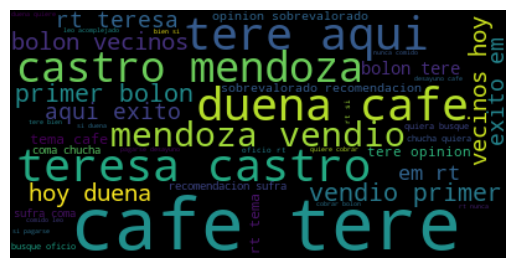

In [18]:
all_content = ' '.join(df["content_filtered"].values)
wordcloud = WordCloud().generate(all_content)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

**Análisis:** La presencia de palabras como "duena", "vendio", "primer", "exito", "hoy", y "opinion" indica que los usuarios están discutiendo eventos recientes relacionados con el negocio.

In [19]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.util import bigrams
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/eeveloza/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

(-0.5, 399.5, 199.5, -0.5)

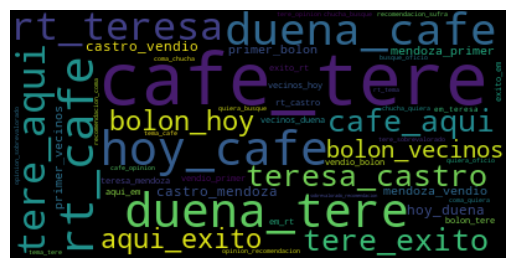

In [20]:
import collections
all_tokens = []
for single_tweet in df["content_filtered"].values:
 tokens = word_tokenize(single_tweet)
 all_tokens += tokens
    
# Se crea el biagrama
bigrams = nltk.collocations.BigramAssocMeasures()
bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(all_tokens,window_size=3)
r_bigrams = list(bigramFinder.score_ngrams(bigrams.raw_freq))
r_bigrams = sorted(r_bigrams, key=lambda tup: tup[1], reverse=True)
r_bigrams_scored = r_bigrams[0:50]
best_ngrams = list(bigramFinder.nbest(bigrams.raw_freq, 50))
ctn = 0
for (x,y),score in r_bigrams_scored:
 ctn += score
results_bigrams = {}
for i,((x,y),score) in enumerate(r_bigrams_scored):
 key = x + "_" + y
 results_bigrams[key] = score
 percent = int(100*score/ctn)
 result = x + "," + y + "," + str(percent) + "%"
    
wordcloud = WordCloud()
_wc = wordcloud.generate_from_frequencies(results_bigrams)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

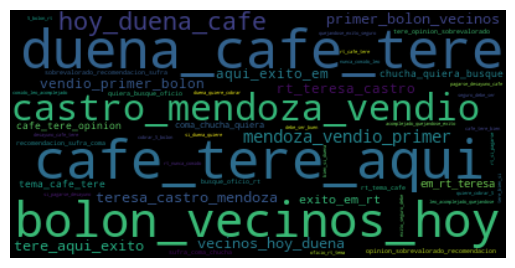

In [24]:
# Se crea el trigrama para posteriormente obtener la nube de palabras

trigrams = nltk.collocations.TrigramAssocMeasures()
trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(all_tokens,window_size=3)
trigrams_scored = list(trigramFinder.score_ngrams(trigrams.raw_freq))
best_trigrams = list(trigramFinder.nbest(trigrams.raw_freq, 50))
trigrams_scored = sorted(trigrams_scored, key=lambda tup: tup[1], reverse=True)
trigrams_scored = trigrams_scored[0:50]
ctn = 0
for (x,y,z),score in trigrams_scored:
  ctn += score
results_trigrams = {}
for i,((x,y,z),score) in enumerate(trigrams_scored):
  key = x + "_" + y + "_" + z
  results_trigrams[key] = score
  percent = int(100*score/ctn)
  result = x + "," + y + "," + z + "," + str(percent) + "%"

wordcloud = WordCloud()
_wc = wordcloud.generate_from_frequencies(results_trigrams)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

**Análisis:** Trigramas como "hoy_duena_cafe" y "duena_cafe_tere" indican que la dueña es una figura central en las discusiones. Hay discusiones recientes sobre la dueña del café.

Tópico 0:
tere bolon rt si ahi cafe verde gusta chicharron comido
Tópico 1:
cafe tere rt aqui hoy exito bolon teresa castro duena
Tópico 2:
tere bolon rt cafe caro si parece puede rico mas
Tópico 3:
rt tere cafe si sobrevalorado tema opinion quiera coma chucha
Tópico 4:
rt tere cafe bolon buen nunca comido ser exito leo


/home/eeveloza/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



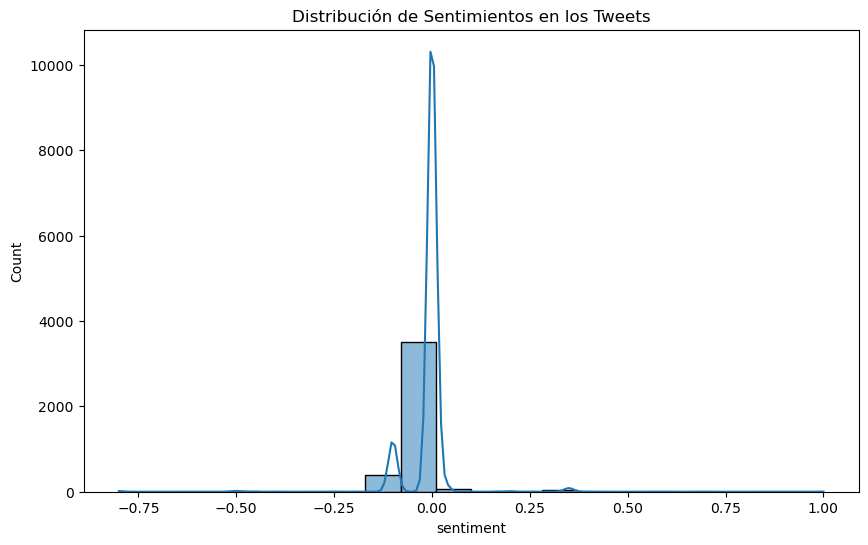

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob

vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=stop_words_list)
dtm = vectorizer.fit_transform(df['content_filtered'])

# Ajustar el modelo LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)  # Ajustar el número de tópicos según sea necesario
lda.fit(dtm)

# Mostrar las palabras clave para cada tópico
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Tópico {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

# Análisis de Sentimientos
df['sentiment'] = df['content_filtered'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Visualizar la distribución del sentimiento
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment'], bins=20, kde=True)
plt.title('Distribución de Sentimientos en los Tweets')
plt.show()

**Distribución Centralizada en Cero:**
La mayor concentración de puntajes de sentimiento se encuentra alrededor de 0, lo que indica que la mayoría de los tweets tienen un sentimiento neutro. Esto sugiere que muchas opiniones expresadas en los tweets no son claramente positivas ni negativas.

**Sesgo Leve hacia el Negativo:**
Hay una pequeña pero notable cantidad de tweets con sentimientos negativos, representados por los puntajes de sentimiento menores a 0.
Estos tweets pueden contener críticas o comentarios negativos sobre "El Café de Tere".

# ¿Cuáles son las temáticas más relevantes de los mensajes?

Es evidente que la temática principal es el Café de Tere. Según las nube de palabras mostradas anteriormente, las temáticas principales tienen que ver con la dueña del Café de Tere, temas relacionados a su negocio, el cual empezó como un emprendimiento. Sin embargo, también existe una pequeña comunidad que se queja del negocio, la palabra sobrevalorado destaca en esta comunidad, también insultos  y palabras negativas.

# ¿La tendencia de opiniones es positiva o negativa?

In [26]:
sentiment = sentiment_analysis.SentimentAnalysisSpanish()
def setimiento(columna):
  sent = sentiment.sentiment(columna)
  return sent

/home/eeveloza/anaconda3/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning:

Trying to unpickle estimator CountVectorizer from version 0.23.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations

/home/eeveloza/anaconda3/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning:

Trying to unpickle estimator MultinomialNB from version 0.23.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations



<Axes: >

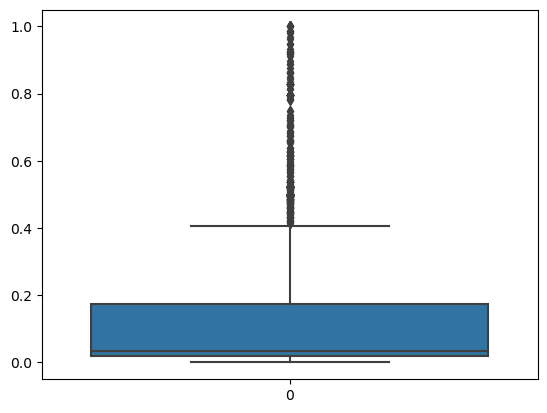

In [28]:
df["sentiment"] = df["content_filtered"].apply(setimiento)
sns.boxplot(df["sentiment"])

In [29]:
df[["text","sentiment"]].sort_values(by="sentiment",ascending=False)

text  \
1157  RT @jvegavara: Te va a dar algo, Tere. Dime cuando quedamos y te invito a un café en el centro comercial Gran Vía de Hortaleza de Madrid, y…   
644   RT @jvegavara: Te va a dar algo, Tere. Dime cuando quedamos y te invito a un café en el centro comercial Gran Vía de Hortaleza de Madrid, y…   
165   RT @jvegavara: Te va a dar algo, Tere. Dime cuando quedamos y te invito a un café en el centro comercial Gran Vía de Hortaleza de Madrid, y…   
1614   Te va a dar algo, Tere. Dime cuando quedamos y te invito a un café en el centro comercial Gran Vía de Hortaleza de… https://t.co/EDTVKkjTtb   
201   Los platos en Tere valen lo que valen por  su excelente servicio, la limpieza de sus locales y porque además sus in… https://t.co/1AlbyTutYO   
...                                                                                                                                            ...   
3543  No saben como seguir dándole mala fama a Guayaquil y lo más triste de estas cuentas que odian a Guayaquil es que vi… https://t.co/FxQZ7jag34   
1667  comida mala es comida mala aquí y en la china.. y por ahi vi a un idiota que decía que si uno era catador de bolone… https://t.co/foU3lZRTCH   
3493  RT @AlvaroBnito: No eres un segundo plato. Eres un menú completo, de esos que podrías estar comiendo días, semanas, meses... Eres un menú d…   
946    Si no te gusta el Café de Tere, si te cae mal, si te parece caro, pues fácil!!! No vayas... de mi parte solo puedo… https://t.co/lzStcyfuuD   
767   RT @karitolina: Si no te gusta el Café de Tere, si te cae mal, si te parece caro, pues fácil!!! No vayas... de mi parte solo puedo decir qu…   

         sentiment  
1157  9.999987e-01  
644   9.999987e-01  
165   9.999987e-01  
1614  9.999522e-01  
201   9.880264e-01  
...            ...  
3543  3.839282e-06  
1667  1.503458e-06  
3493  1.277464e-06  
946   1.084318e-06  
767   6.590051e-07  

[4014 rows x 2 columns]

# Sección de usuarios con comunidades

In [31]:
!pip install stanza
import stanza
stanza.download("es")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.1/990.1 kB 8.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.2/779.2 MB 3.8 MB/s eta 0:00:0000:0100:05m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.4 MB/s eta 0:00:0000:0100:03m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 5.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 8.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 8.8 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 3.6 MB/s eta 0:00:0000:0100:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 6.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 1.1 MB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 3.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 4.2 MB/s eta 0:00:0000:0100:01m


2024-05-25 23:00:02 INFO: Downloaded file to /home/eeveloza/stanza_resources/resources.json
2024-05-25 23:00:02 INFO: Downloading default packages for language: es (Spanish) ...


2024-05-25 23:00:44 INFO: Downloaded file to /home/eeveloza/stanza_resources/es/default.zip
2024-05-25 23:00:47 INFO: Finished downloading models and saved to /home/eeveloza/stanza_resources


In [32]:
nlp = stanza.Pipeline(lang='es', processors='tokenize,mwt,pos,lemma')


def apply_lemmatization(text):
 doc = nlp(text)
 text_lemma = ""
 lemmas = []
 for sent in doc.sentences:
   for token in sent.words:
     lemmas.append(token.lemma)
 return " ".join(lemmas)

2024-05-25 23:01:39 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-05-25 23:01:39 INFO: Downloaded file to /home/eeveloza/stanza_resources/resources.json
2024-05-25 23:01:39 INFO: Loading these models for language: es (Spanish):
| Processor | Package         |
-------------------------------
| tokenize  | ancora          |
| mwt       | ancora          |
| pos       | ancora_charlm   |
| lemma     | ancora_nocharlm |

2024-05-25 23:01:39 INFO: Using device: cuda
2024-05-25 23:01:39 INFO: Loading: tokenize
2024-05-25 23:01:40 INFO: Loading: mwt
2024-05-25 23:01:40 INFO: Loading: pos
2024-05-25 23:01:40 INFO: Loading: lemma
2024-05-25 23:01:40 INFO: Done loading processors!


In [33]:
from unidecode import unidecode


# Function to remove accents using unidecode
def remove_accents(text):
   if isinstance(text, str):
       return unidecode(text)
   else:
       return text


In [34]:
df.columns

Index(['created_at', 'retweet_count', 'favorite_count', 'text',
       'retweeted_status_id', 'user_screen_name', 'user_id',
       'user_description', 'user_location', 'user_mentions',
       'entities_hashtags_text', 'content_filtered', 'sentiment'],
      dtype='object')

In [35]:
df["content_filtered"] = df["content_filtered"].apply(apply_lemmatization)
df["content_filtered"] = df["content_filtered"].apply(remove_accents)

(-0.5, 399.5, 199.5, -0.5)

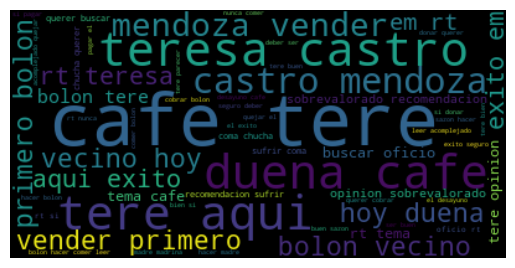

In [36]:
all_content = ' '.join(df["content_filtered"].values)
wordcloud = WordCloud().generate(all_content)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [37]:
corpus = df["content_filtered"].values

In [38]:
from sklearn.feature_extraction.text import  TfidfVectorizer
tfidf = TfidfVectorizer(min_df=10)
tfidf_matrix = tfidf.fit_transform(corpus)

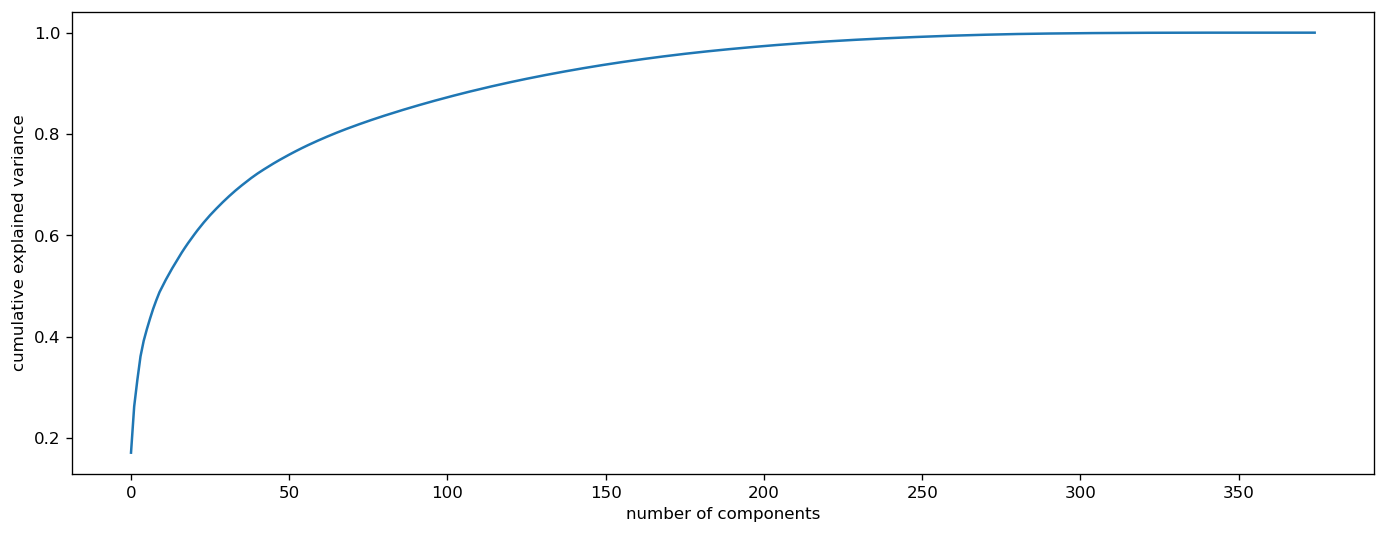

In [39]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np


pca = PCA()
pca.fit(tfidf_matrix.toarray())
# Lets plot explained var v/s comp to check how many components to be considered.
plt.figure(figsize=(14,5), dpi=120)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [40]:
pca_tuned = PCA(n_components=200)
pca_tuned.fit(tfidf_matrix.toarray())
X_transformed = pca_tuned.transform(tfidf_matrix.toarray())


columns = [ "pc_"+str(i) for i in range(0,pca_tuned.n_components_) ]
df_pca = pd.DataFrame(data=X_transformed,columns=columns)

In [41]:
from sklearn.cluster import KMeans
import numpy as np

/home/eeveloza/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/eeveloza/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/eeveloza/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/eeveloza/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/eeveloza/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_k

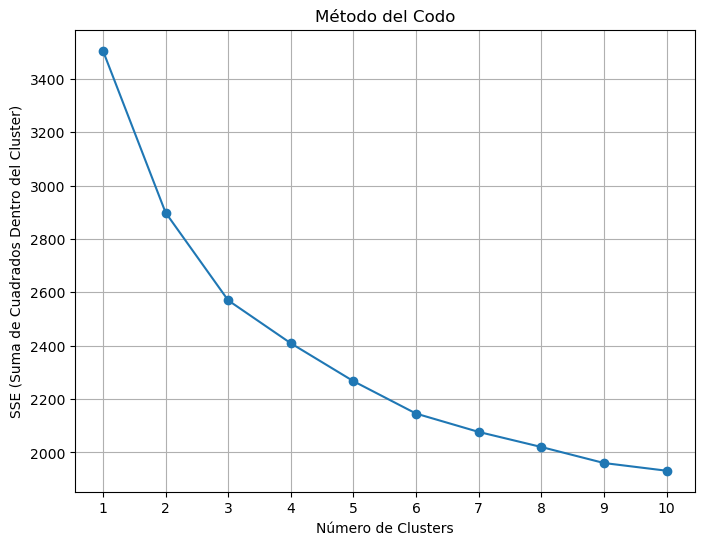

In [42]:
# elbow method
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_transformed)
    sse.append(kmeans.inertia_)

# Graficar el codo
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('SSE (Suma de Cuadrados Dentro del Cluster)')
plt.xticks(np.arange(1, 11, 1))
plt.grid(True)
plt.show()

In [43]:
# Usarmeos 5 clusters
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, n_init=5,max_iter=500, random_state=42)
kmeans.fit(X_transformed)
df_pca["cluster"] = kmeans.labels_

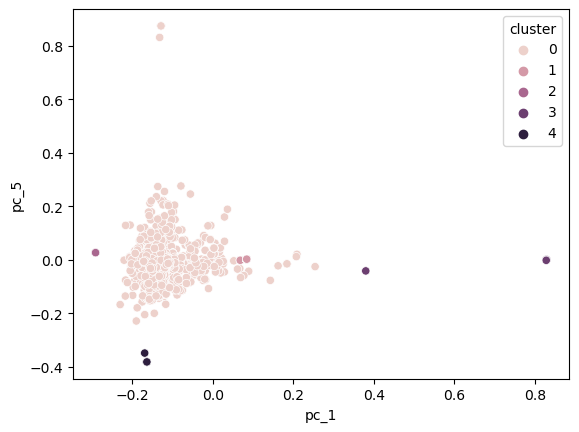

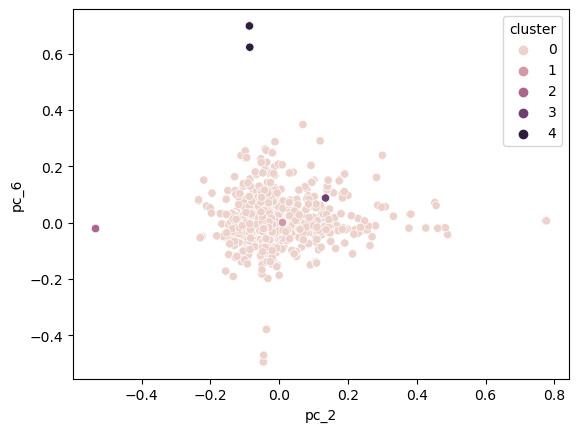

In [44]:
sns.scatterplot(x="pc_1",y="pc_5",hue="cluster",data=df_pca)
plt.show()
sns.scatterplot(x="pc_2",y="pc_6",hue="cluster",data=df_pca)
plt.show()

In [45]:
df["clusters"] = df_pca["cluster"]

In [46]:
corpus_group_1 = df[df["clusters"]==0]["content_filtered"]
corpus_group_2 = df[df["clusters"]==1]["content_filtered"]
corpus_group_3 = df[df["clusters"]==2]["content_filtered"]
corpus_group_4 = df[df["clusters"]==3]["content_filtered"]
corpus_group_5 = df[df["clusters"]==4]["content_filtered"]

all_content_group_1 = ' '.join(corpus_group_1)
all_content_group_2 = ' '.join(corpus_group_2)
all_content_group_3 = ' '.join(corpus_group_3)
all_content_group_4 = ' '.join(corpus_group_4)
all_content_group_5 = ' '.join(corpus_group_5)

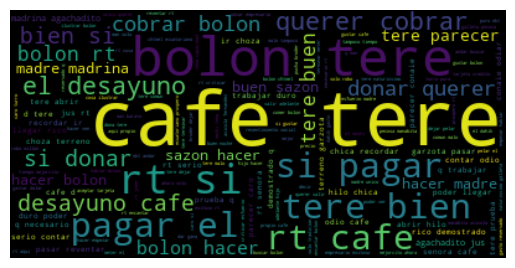

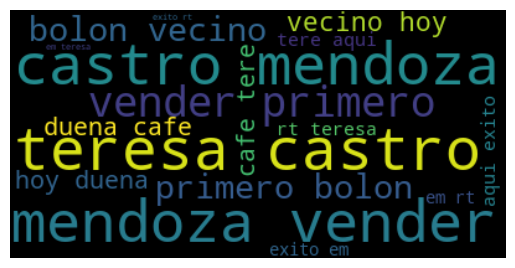

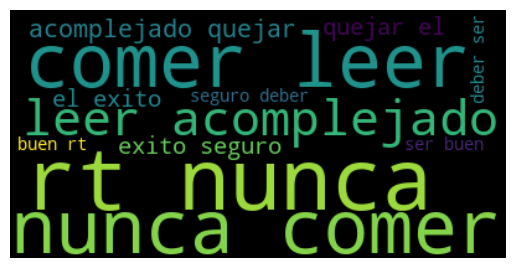

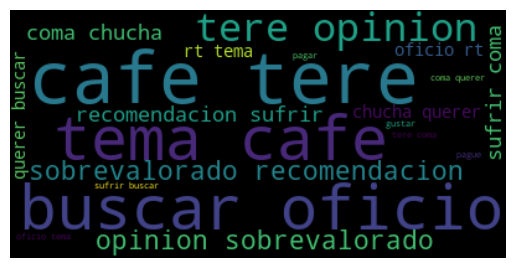

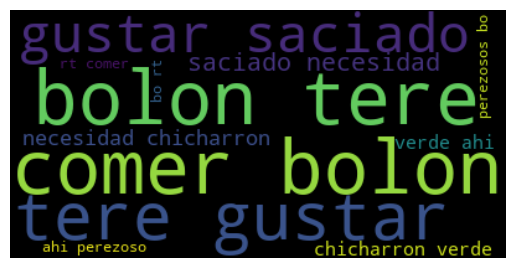

In [47]:
wordcloud = WordCloud().generate(all_content_group_1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud = WordCloud().generate(all_content_group_2)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud = WordCloud().generate(all_content_group_3)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud = WordCloud().generate(all_content_group_4)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud = WordCloud().generate(all_content_group_5)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [48]:
all_tokens_1 = []
for single_tweet in corpus_group_1.values:
 tokens = word_tokenize(single_tweet)
 all_tokens_1 += tokens

all_tokens_2 = []
for single_tweet in corpus_group_2.values:
 tokens = word_tokenize(single_tweet)
 all_tokens_2 += tokens

all_tokens_3 = []
for single_tweet in corpus_group_3.values:
 tokens = word_tokenize(single_tweet)
 all_tokens_3 += tokens

all_tokens_4 = []
for single_tweet in corpus_group_4.values:
 tokens = word_tokenize(single_tweet)
 all_tokens_4 += tokens

 all_tokens_5 = []
for single_tweet in corpus_group_5.values:
 tokens = word_tokenize(single_tweet)
 all_tokens_5 += tokens

In [49]:
bigrams = nltk.collocations.BigramAssocMeasures()
bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(all_tokens_1,window_size=3)
r_bigrams = list(bigramFinder.score_ngrams(bigrams.raw_freq))
r_bigrams = sorted(r_bigrams, key=lambda tup: tup[1], reverse=True)
r_bigrams_scored = r_bigrams[0:50]
ctn = 0
for (x,y),score in r_bigrams_scored:
 ctn += score
results_bigrams_1 = {}
for i,((x,y),score) in enumerate(r_bigrams_scored):
 key = x + "_" + y
 results_bigrams_1[key] = score
 percent = int(100*score/ctn)
 result = x + "," + y + "," + str(percent) + "%"
 #print(result)

bigrams = nltk.collocations.BigramAssocMeasures()
bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(all_tokens_2,window_size=3)
r_bigrams = list(bigramFinder.score_ngrams(bigrams.raw_freq))
r_bigrams = sorted(r_bigrams, key=lambda tup: tup[1], reverse=True)
r_bigrams_scored = r_bigrams[0:50]
ctn = 0
for (x,y),score in r_bigrams_scored:
 ctn += score
results_bigrams_2 = {}
for i,((x,y),score) in enumerate(r_bigrams_scored):
 key = x + "_" + y
 results_bigrams_2[key] = score
 percent = int(100*score/ctn)
 result = x + "," + y + "," + str(percent) + "%"
 #print(result)

bigrams = nltk.collocations.BigramAssocMeasures()
bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(all_tokens_3,window_size=3)
r_bigrams = list(bigramFinder.score_ngrams(bigrams.raw_freq))
r_bigrams = sorted(r_bigrams, key=lambda tup: tup[1], reverse=True)
r_bigrams_scored = r_bigrams[0:50]
ctn = 0
for (x,y),score in r_bigrams_scored:
 ctn += score
results_bigrams_3 = {}
for i,((x,y),score) in enumerate(r_bigrams_scored):
 key = x + "_" + y
 results_bigrams_3[key] = score
 percent = int(100*score/ctn)
 result = x + "," + y + "," + str(percent) + "%"
 #print(result)

bigrams = nltk.collocations.BigramAssocMeasures()
bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(all_tokens_4,window_size=3)
r_bigrams = list(bigramFinder.score_ngrams(bigrams.raw_freq))
r_bigrams = sorted(r_bigrams, key=lambda tup: tup[1], reverse=True)
r_bigrams_scored = r_bigrams[0:50]
ctn = 0
for (x,y),score in r_bigrams_scored:
 ctn += score
results_bigrams_4 = {}
for i,((x,y),score) in enumerate(r_bigrams_scored):
 key = x + "_" + y
 results_bigrams_4[key] = score
 percent = int(100*score/ctn)
 result = x + "," + y + "," + str(percent) + "%"
 #print(result)

bigrams = nltk.collocations.BigramAssocMeasures()
bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(all_tokens_5,window_size=3)
r_bigrams = list(bigramFinder.score_ngrams(bigrams.raw_freq))
r_bigrams = sorted(r_bigrams, key=lambda tup: tup[1], reverse=True)
r_bigrams_scored = r_bigrams[0:50]
ctn = 0
for (x,y),score in r_bigrams_scored:
 ctn += score
results_bigrams_5 = {}
for i,((x,y),score) in enumerate(r_bigrams_scored):
 key = x + "_" + y
 results_bigrams_5[key] = score
 percent = int(100*score/ctn)
 result = x + "," + y + "," + str(percent) + "%"
 #print(result)

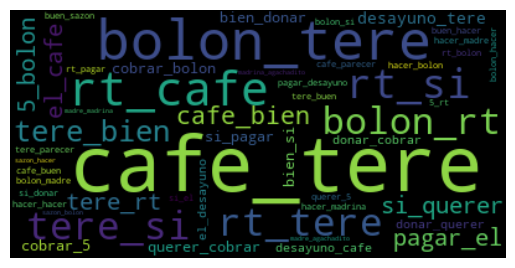

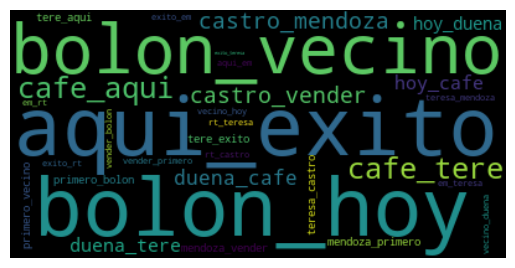

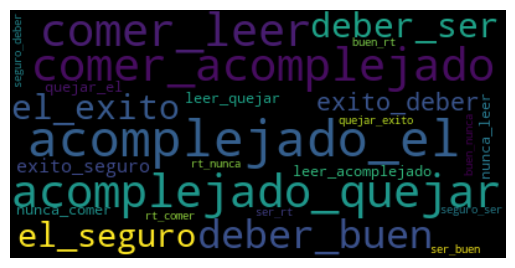

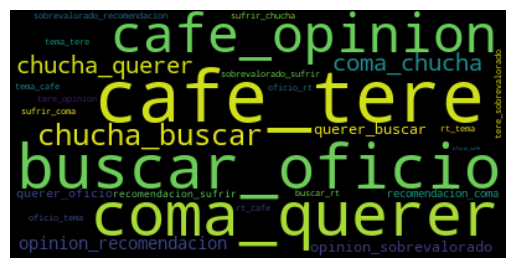

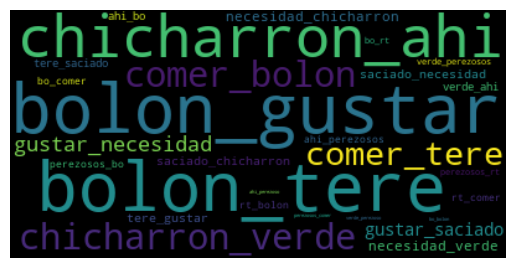

In [50]:
wordcloud = WordCloud()
_wc = wordcloud.generate_from_frequencies(results_bigrams_1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud = WordCloud()
_wc = wordcloud.generate_from_frequencies(results_bigrams_2)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud = WordCloud()
_wc = wordcloud.generate_from_frequencies(results_bigrams_3)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud = WordCloud()
_wc = wordcloud.generate_from_frequencies(results_bigrams_4)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud = WordCloud()
_wc = wordcloud.generate_from_frequencies(results_bigrams_5)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [51]:
trigrams = nltk.collocations.TrigramAssocMeasures()
trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(all_tokens_1,window_size=3)
trigrams_scored = list(trigramFinder.score_ngrams(trigrams.raw_freq))
best_trigrams = list(trigramFinder.nbest(trigrams.raw_freq, 50))
trigrams_scored = sorted(trigrams_scored, key=lambda tup: tup[1], reverse=True)
trigrams_scored = trigrams_scored[0:50]
ctn = 0
for (x,y,z),score in trigrams_scored:
 ctn += score
results_trigrams_1 = {}
for i,((x,y,z),score) in enumerate(trigrams_scored):
 key = x + "_" + y + "_" + z
 results_trigrams_1[key] = score
 percent = int(100*score/ctn)
 result = x + "," + y + "," + z + "," + str(percent) + "%"
 #print(result)

 trigrams = nltk.collocations.TrigramAssocMeasures()
trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(all_tokens_2,window_size=3)
trigrams_scored = list(trigramFinder.score_ngrams(trigrams.raw_freq))
best_trigrams = list(trigramFinder.nbest(trigrams.raw_freq, 50))
trigrams_scored = sorted(trigrams_scored, key=lambda tup: tup[1], reverse=True)
trigrams_scored = trigrams_scored[0:50]
ctn = 0
for (x,y,z),score in trigrams_scored:
 ctn += score
results_trigrams_2 = {}
for i,((x,y,z),score) in enumerate(trigrams_scored):
 key = x + "_" + y + "_" + z
 results_trigrams_2[key] = score
 percent = int(100*score/ctn)
 result = x + "," + y + "," + z + "," + str(percent) + "%"
 #print(result)

trigrams = nltk.collocations.TrigramAssocMeasures()
trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(all_tokens_3,window_size=3)
trigrams_scored = list(trigramFinder.score_ngrams(trigrams.raw_freq))
best_trigrams = list(trigramFinder.nbest(trigrams.raw_freq, 50))
trigrams_scored = sorted(trigrams_scored, key=lambda tup: tup[1], reverse=True)
trigrams_scored = trigrams_scored[0:50]
ctn = 0
for (x,y,z),score in trigrams_scored:
 ctn += score
results_trigrams_3 = {}
for i,((x,y,z),score) in enumerate(trigrams_scored):
 key = x + "_" + y + "_" + z
 results_trigrams_3[key] = score
 percent = int(100*score/ctn)
 result = x + "," + y + "," + z + "," + str(percent) + "%"
 #print(result)

trigrams = nltk.collocations.TrigramAssocMeasures()
trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(all_tokens_4,window_size=3)
trigrams_scored = list(trigramFinder.score_ngrams(trigrams.raw_freq))
best_trigrams = list(trigramFinder.nbest(trigrams.raw_freq, 50))
trigrams_scored = sorted(trigrams_scored, key=lambda tup: tup[1], reverse=True)
trigrams_scored = trigrams_scored[0:50]
ctn = 0
for (x,y,z),score in trigrams_scored:
 ctn += score
results_trigrams_4 = {}
for i,((x,y,z),score) in enumerate(trigrams_scored):
 key = x + "_" + y + "_" + z
 results_trigrams_4[key] = score
 percent = int(100*score/ctn)
 result = x + "," + y + "," + z + "," + str(percent) + "%"
 #print(result)

trigrams = nltk.collocations.TrigramAssocMeasures()
trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(all_tokens_5,window_size=3)
trigrams_scored = list(trigramFinder.score_ngrams(trigrams.raw_freq))
best_trigrams = list(trigramFinder.nbest(trigrams.raw_freq, 50))
trigrams_scored = sorted(trigrams_scored, key=lambda tup: tup[1], reverse=True)
trigrams_scored = trigrams_scored[0:50]
ctn = 0
for (x,y,z),score in trigrams_scored:
 ctn += score
results_trigrams_5 = {}
for i,((x,y,z),score) in enumerate(trigrams_scored):
 key = x + "_" + y + "_" + z
 results_trigrams_5[key] = score
 percent = int(100*score/ctn)
 result = x + "," + y + "," + z + "," + str(percent) + "%"
 #print(result)

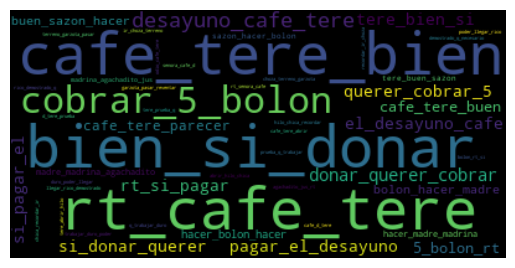

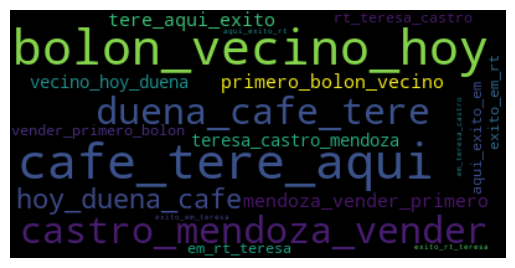

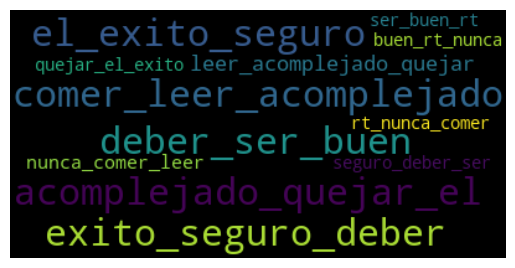

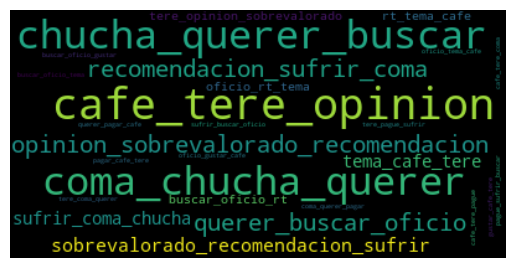

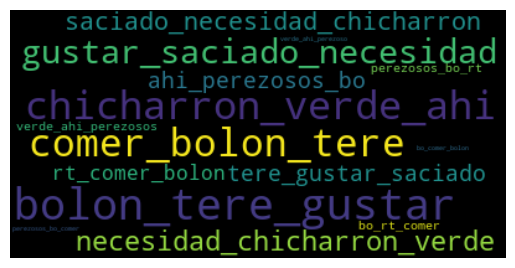

In [52]:
wordcloud = WordCloud()
_wc = wordcloud.generate_from_frequencies(results_trigrams_1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud = WordCloud()
_wc = wordcloud.generate_from_frequencies(results_trigrams_2)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud = WordCloud()
_wc = wordcloud.generate_from_frequencies(results_trigrams_3)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud = WordCloud()
_wc = wordcloud.generate_from_frequencies(results_trigrams_4)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud = WordCloud()
_wc = wordcloud.generate_from_frequencies(results_trigrams_5)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [53]:
df["user_description"] = df["user_description"].astype(str)
df["descripcion_user"] = df["user_description"].apply(process_text)
df["descripcion_user"] = df["descripcion_user"].apply(remove_stopwords)
df["descripcion_user"] = df["descripcion_user"].apply(remove_accents)

(-0.5, 399.5, 199.5, -0.5)

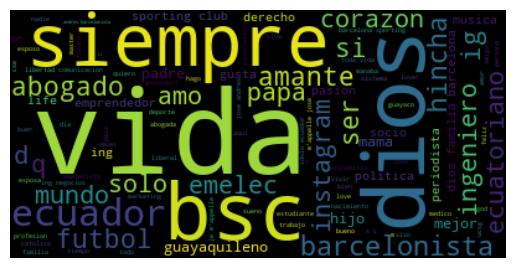

In [54]:
all_content = ' '.join(df["descripcion_user"].values)
wordcloud = WordCloud().generate(all_content)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [56]:
df_users = df.loc[df["user_description"]!="nan"]
df_users["favorite_count"] = df_users["favorite_count"].astype(float)
df_user_top = df_users[df_users["clusters"]==0].sort_values(by="favorite_count",ascending=False).head(30)

In [57]:
for i in range(1,5):
  df_user_top = pd.concat([df_user_top,df_users[df_users["clusters"]==i].sort_values(by="favorite_count",ascending=False).head(30)])

In [58]:
corpus_group_1 = df_user_top[df_user_top["clusters"]==0]["descripcion_user"]
corpus_group_2 = df_user_top[df_user_top["clusters"]==1]["descripcion_user"]
corpus_group_3 = df_user_top[df_user_top["clusters"]==2]["descripcion_user"]
corpus_group_4 = df_user_top[df_user_top["clusters"]==3]["descripcion_user"]
corpus_group_5 = df_user_top[df_user_top["clusters"]==4]["descripcion_user"]

all_content_group_1 = ' '.join(corpus_group_1)
all_content_group_2 = ' '.join(corpus_group_2)
all_content_group_3 = ' '.join(corpus_group_3)
all_content_group_4 = ' '.join(corpus_group_4)
all_content_group_5 = ' '.join(corpus_group_5)

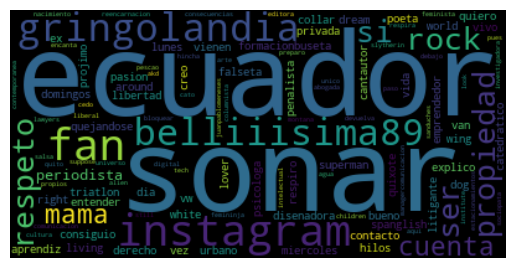

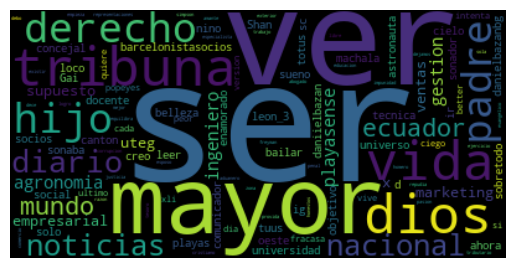

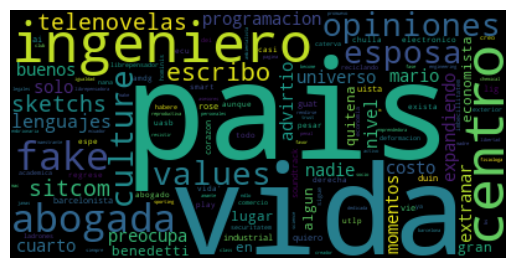

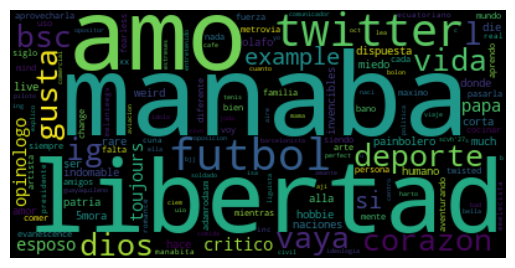

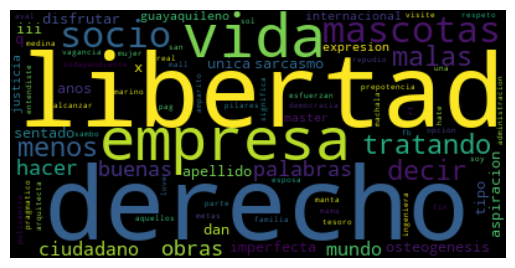

In [59]:
wordcloud = WordCloud().generate(all_content_group_1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud = WordCloud().generate(all_content_group_2)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud = WordCloud().generate(all_content_group_3)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud = WordCloud().generate(all_content_group_4)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud = WordCloud().generate(all_content_group_5)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()